# RQ2: **What is the impact of the initial state on the optimizers' convergence speed, settling time, and optimal gain values?** 

In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from src.analysis.optimizers_results_schemas import (
    BayesianOptimizerResults,
    DifferentialEvolutionResults,
)
from src.analysis.analysis_utils import (
    generate_dict,
    populate_optimizer_results,
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
%matplotlib inline

In [3]:
DE_RESULTS_DIR = (
    "../DE-results"
)
BO_RESULTS_DIR = (
    "../BO-results"
)

assert os.path.exists(DE_RESULTS_DIR)
assert os.path.exists(BO_RESULTS_DIR)

In [4]:
CONFIGS = [f"config_{i}" for i in range(1, 4)]
TRIALS = [f"trial_{i}" for i in range(1, 2)]
INIT_FILES = ["csv", "txt"]

de_dict = generate_dict(CONFIGS, TRIALS, INIT_FILES)
bo_dict = generate_dict(CONFIGS, TRIALS, INIT_FILES)

In [5]:
de_dict = populate_optimizer_results(
    optimizer_results=DE_RESULTS_DIR, empty_dict=de_dict
)
bo_dict = populate_optimizer_results(
    optimizer_results=BO_RESULTS_DIR, empty_dict=bo_dict
)

In [6]:
de_results = DifferentialEvolutionResults(**de_dict)
bo_results = BayesianOptimizerResults(**bo_dict)

In [7]:
header = [
    "Initial State",
    "Optimizer",
    "Time (s)",
    "# Iterations",
    "Settling Time (ms)",
    "Steady State Error %",
    "Kp",
    "Ki",
    "Kd",
]

rows = []

for init_index in range(6):
    # Loop for Bayesian Optimizer
    for config in [bo_results.config_1]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Bayesian Optimizer",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )
        else:
            rows.append(
                [
                    init_index,
                    "Bayesian Optimizer",
                    "didn't converge",
                    "150",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                ]
            )

    for config in [de_results.config_3]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Differential Evolution",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )
        else:
            rows.append(
                [
                    init_index,
                    "Bayesian Optimizer",
                    "didn't converge",
                    "150",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                ]
            )
df = pd.DataFrame(rows, columns=header)


df.style.set_table_styles(
    [
        dict(selector="th", props=[("font-size", "10pt")]),
        dict(selector="td", props=[("font-size", "10pt")]),
    ]
)


,Initial State,Optimizer,Time (s),# Iterations,Settling Time (ms),Steady State Error %,Kp,Ki,Kd
0,0,Bayesian Optimizer,44.602983,3,2400,2.440000,10.907680,0.330117,0.127006
1,0,Differential Evolution,350.970100,31,2400,1.550000,16.000000,0.000000,0.964265
2,1,Bayesian Optimizer,73.686447,5,1300,0.190000,18.249986,0.740096,0.708124
3,1,Differential Evolution,1452.322558,126,1800,3.310000,23.703049,0.261754,0.971221
4,2,Bayesian Optimizer,115.916155,8,1600,-0.530000,6.788276,0.049277,0.409347
5,2,Differential Evolution,364.306251,36,1400,2.090000,6.432000,0.078199,0.782228
6,3,Bayesian Optimizer,7396.854886,121,1100,-0.170000,17.801146,0.670552,0.476415
7,3,Differential Evolution,581.676998,46,1800,1.400000,18.723926,0.162630,0.471297
8,4,Bayesian Optimizer,4358.023055,115,1300,-0.160000,4.930022,0.085849,0.263449
9,4,Differential Evolution,146.397303,11,2500,17.350000,20.154038,0.070000,0.892000


In [8]:
df_balanced = pd.DataFrame(rows, columns=header)
de_settling_time_balanced = df_balanced[
    df_balanced["Optimizer"] == "Differential Evolution"
]["Settling Time (ms)"].values
de_settling_time_balanced = de_settling_time_balanced[
    de_settling_time_balanced != "didn't converge"
]

bo_settling_time_balanced = df_balanced[
    df_balanced["Optimizer"] == "Bayesian Optimizer"
]["Settling Time (ms)"].values
bo_settling_time_balanced = bo_settling_time_balanced[
    bo_settling_time_balanced != "didn't converge"
]

de_sse_balanced = df_balanced[
    df_balanced["Optimizer"] == "Differential Evolution"
]["Steady State Error %"].values
de_sse_balanced = de_sse_balanced[de_sse_balanced != "didn't converge"]
bo_sse_balanced = df_balanced[
    df_balanced["Optimizer"] == "Bayesian Optimizer"
]["Steady State Error %"].values
bo_sse_balanced = bo_sse_balanced[bo_sse_balanced != "didn't converge"]

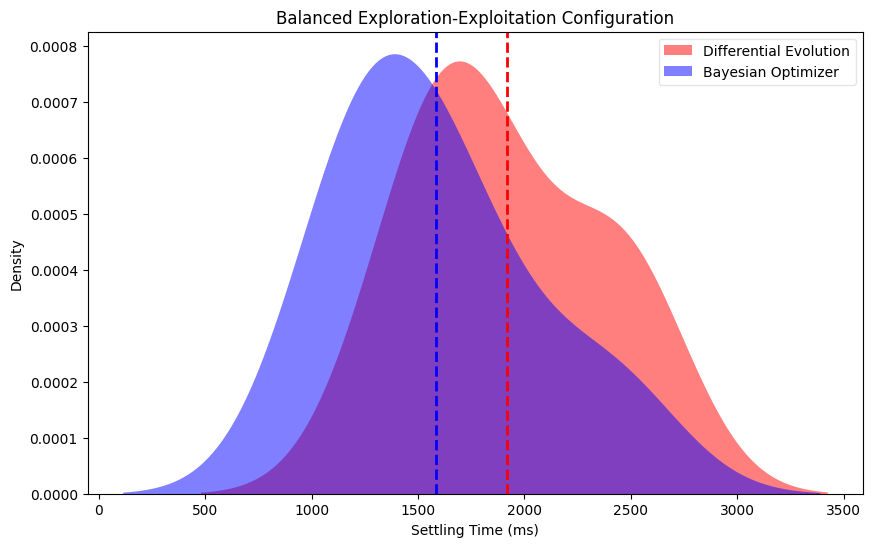

In [9]:
sns.kdeplot(
    de_settling_time_balanced,
    color="red",
    label="Differential Evolution",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)
sns.kdeplot(
    bo_settling_time_balanced,
    color="blue",
    label="Bayesian Optimizer",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

plt.title("Balanced Exploration-Exploitation Configuration")
plt.ylabel("Density")
plt.xlabel("Settling Time (ms)")
plt.axvline(
    np.mean(de_settling_time_balanced),
    color="red",
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(bo_settling_time_balanced),
    color="blue",
    linestyle="dashed",
    linewidth=2,
)
plt.legend(fancybox=True, framealpha=0.5)
plt.show()

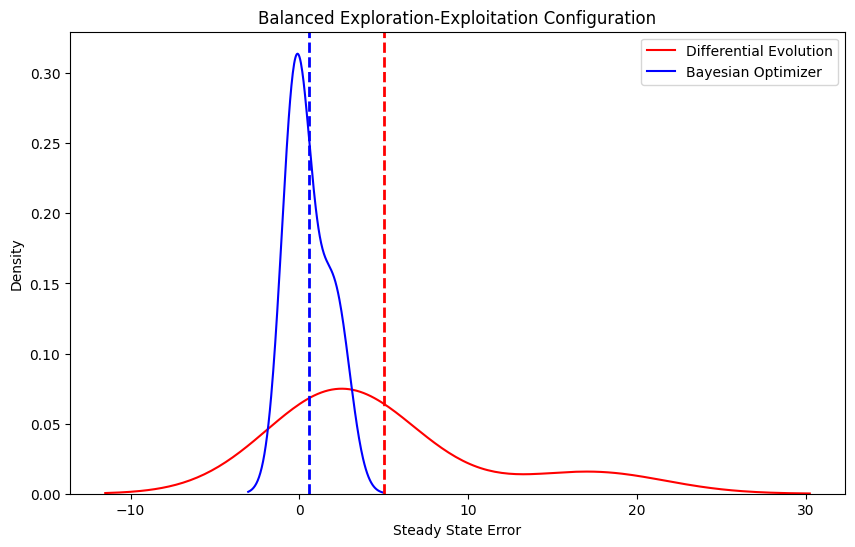

In [10]:
sns.kdeplot(de_sse_balanced, label="Differential Evolution", color="red")
sns.kdeplot(bo_sse_balanced, label="Bayesian Optimizer", color="blue")
plt.xlabel("Steady State Error")
plt.ylabel("Density")
plt.axvline(
    np.mean(de_sse_balanced), color="red", linestyle="dashed", linewidth=2
)
plt.axvline(
    np.mean(bo_sse_balanced), color="blue", linestyle="dashed", linewidth=2
)
plt.title("Balanced Exploration-Exploitation Configuration")
plt.legend()
plt.show()

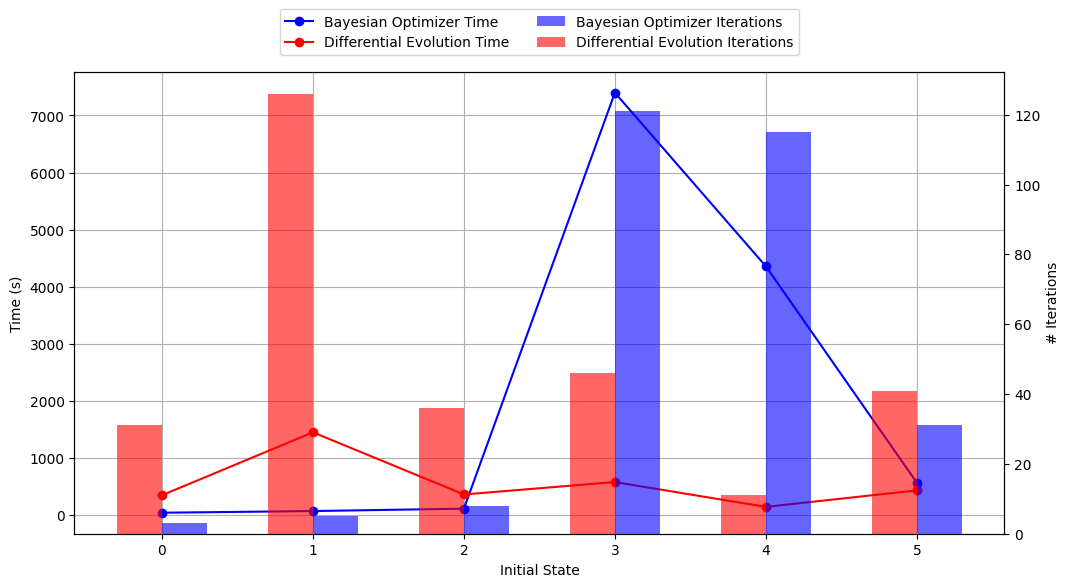

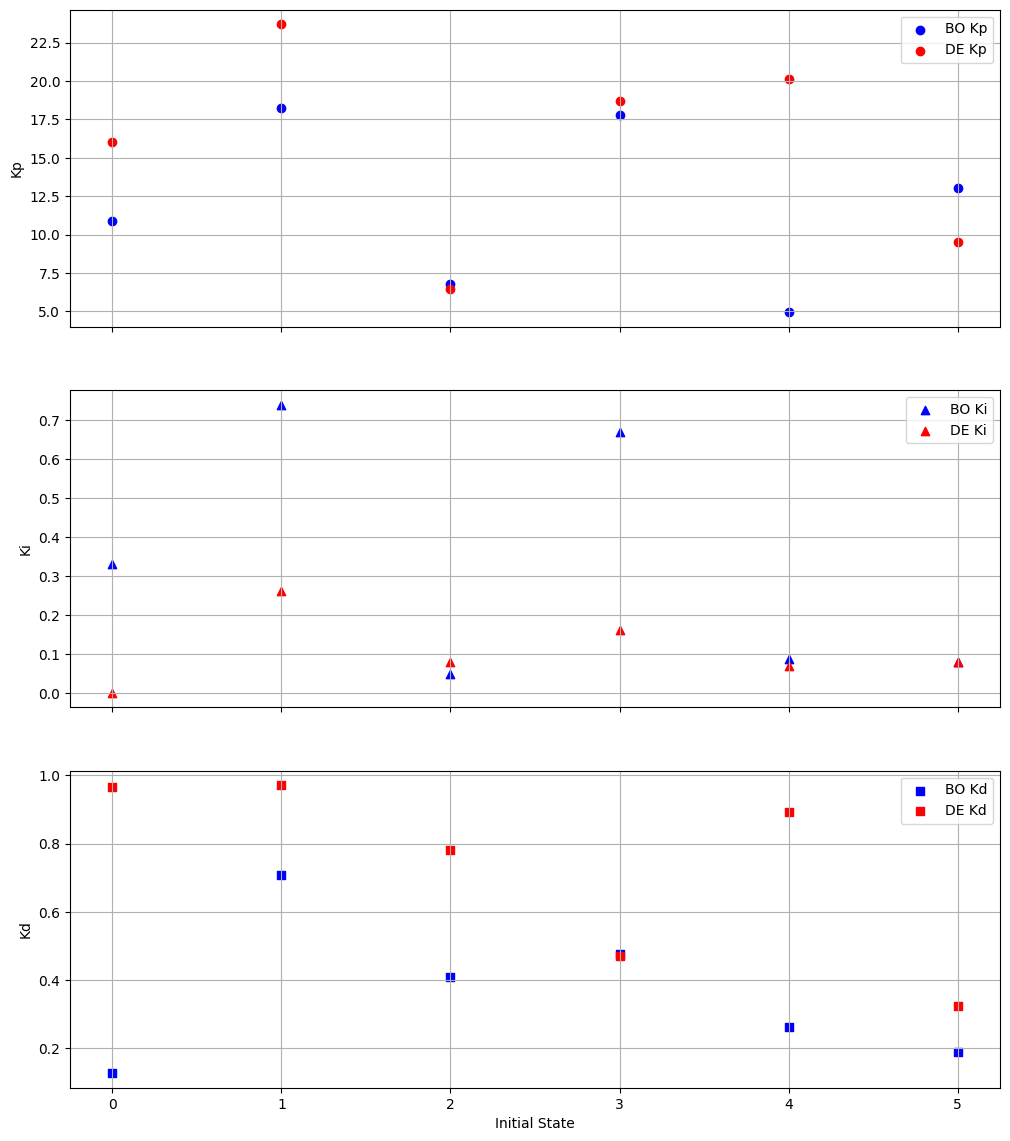

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6))

for opt_id in df_balanced["Optimizer"].unique():
    subset = df_balanced[df_balanced["Optimizer"] == opt_id]
    ax1.plot(
        subset["Initial State"],
        subset["Time (s)"],
        marker="o",
        label=f"{opt_id} Time",
        linestyle="-",
        color="blue" if opt_id == "Bayesian Optimizer" else "red",
    )

ax1.set_xlabel("Initial State")
ax1.set_ylabel("Time (s)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.grid(True)

ax2 = ax1.twinx()
for opt_id in df_balanced["Optimizer"].unique():
    subset = df_balanced[df_balanced["Optimizer"] == opt_id]
    ax2.bar(
        subset["Initial State"] + (0.15 if opt_id == "Bayesian Optimizer" else -0.15),
        subset["# Iterations"],
        width=0.3,
        alpha=0.6,
        label=f"{opt_id} Iterations",
        color="blue" if opt_id == "Bayesian Optimizer" else "red",
    )

ax2.set_ylabel("# Iterations", color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines + lines2,
    labels + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=2,
)

plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

ax1.scatter(
    df_balanced[df_balanced["Optimizer"] == "Bayesian Optimizer"]["Initial State"],
    df_balanced[df_balanced["Optimizer"] == "Bayesian Optimizer"]["Kp"],
    color="blue",
    label="BO Kp",
    marker="o",
)
ax1.scatter(
    df_balanced[df_balanced["Optimizer"] == "Differential Evolution"]["Initial State"],
    df_balanced[df_balanced["Optimizer"] == "Differential Evolution"]["Kp"],
    color="red",
    label="DE Kp",
    marker="o",
)
ax1.set_ylabel("Kp")
ax1.grid(True)
ax1.legend()

ax2.scatter(
    df_balanced[df_balanced["Optimizer"] == "Bayesian Optimizer"]["Initial State"],
    df_balanced[df_balanced["Optimizer"] == "Bayesian Optimizer"]["Ki"],
    color="blue",
    label="BO Ki",
    marker="^",
)
ax2.scatter(
    df_balanced[df_balanced["Optimizer"] == "Differential Evolution"]["Initial State"],
    df_balanced[df_balanced["Optimizer"] == "Differential Evolution"]["Ki"],
    color="red",
    label="DE Ki",
    marker="^",
)
ax2.set_ylabel("Ki")
ax2.grid(True)
ax2.legend()

ax3.scatter(
    df_balanced[df_balanced["Optimizer"] == "Bayesian Optimizer"]["Initial State"],
    df_balanced[df_balanced["Optimizer"] == "Bayesian Optimizer"]["Kd"],
    color="blue",
    label="BO Kd",
    marker="s",
)
ax3.scatter(
    df_balanced[df_balanced["Optimizer"] == "Differential Evolution"]["Initial State"],
    df_balanced[df_balanced["Optimizer"] == "Differential Evolution"]["Kd"],
    color="red",
    label="DE Kd",
    marker="s",
)
ax3.set_xlabel("Initial State")
ax3.set_ylabel("Kd")
ax3.grid(True)
ax3.legend()

plt.show()